# Week 7 Lab - Spatial Packages

## Part 1 - Where do you live?

Import wanted packages

In [38]:
from geopy.geocoders import Nominatim
from geopy.distance import vincenty

In [3]:
geolocator = Nominatim(user_agent = 'k1896419@kcl.ac.uk')

In [31]:
home_address = geolocator.geocode('3 Boleyn Road, London')
#home_address = geolocator.geocode('3 Boleyn Road, London', exactly_one = False)

In [33]:
print(home_address)

Boleyn Road, Mayville Estate, Kingsland, London Borough of Hackney, London, Greater London, England, N16 8UZ, UK


In [35]:
home_lat_lon = (home_address.latitude,home_address.longitude)
print(home_lat_lon)

(51.5496183, -0.0777906)


In [70]:
kings = (51.5146458,-0.118014653020563)
kings_loc = geolocator.reverse(kings)

In [46]:
d = vincenty(home_lat_lon,kings)
print('HOME->UNI %s miles' % d.miles)
print('HOME->UNI %s feet' % d.feet)
print('HOME->UNI %s km' % d.km)
print('HOME->UNI %s meters' % d.meters)

HOME->UNI 2.97549540402401 miles
HOME->UNI 15710.615733246772 feet
HOME->UNI 4.7885956754936165 km
HOME->UNI 4788.595675493617 meters


## Part 2 - Which London ward do you live in?

In [66]:
import fiona
import pyproj
from shapely.geometry import Point
from shapely.geometry import shape

In [49]:
wards = fiona.open('data/London_Ward.shp', 'r')
print("London_Wards : %d features" % len(wards))

London_Wards : 654 features


In [95]:
print('Geometry type: %s' % wards.schema["geometry"])
print('Properties: %s' % list(wards.schema["properties"].keys()))
print('CRS: %s' % wards.crs_wkt)

Geometry type: Polygon
Properties: ['NAME', 'GSS_CODE', 'HECTARES', 'NONLD_AREA', 'LB_GSS_CD', 'BOROUGH', 'POLY_ID']
CRS: PROJCS["British_National_Grid",GEOGCS["GCS_OSGB_1936",DATUM["OSGB_1936",SPHEROID["Airy_1830",6377563.396,299.3249646]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",400000],PARAMETER["False_Northing",-100000],PARAMETER["Central_Meridian",-2],PARAMETER["Scale_Factor",0.999601272],PARAMETER["Latitude_Of_Origin",49],UNIT["Meter",1]]


In [126]:
bng = pyproj.Proj(init = 'epsg:27700')
wgs84 = pyproj.Proj(init = 'epsg:4326')

x,y = pyproj.transform(wgs84,bng,home_address.longitude,home_address.latitude)
print(x,y)
kx,ky = pyproj.transform(wgs84,bng,kings_loc.longitude,kings_loc.latitude)
print(kx,ky)

533375.809901109 185164.85879958922
530687.0852444146 181203.2667799407


In [127]:
home_pnt = Point(x,y)
print(home_pnt)
kings_pnt = Point(kx,ky)
print(kings_pnt)

POINT (533375.809901109 185164.8587995892)
POINT (530687.0852444146 181203.2667799407)


In [133]:
q = [w for w in wards if home_pnt.within(shape(w["geometry"]))]
l = len(q)
d = dict(q[0]["properties"])

In [134]:
print("Borough: %s , Name: %s" % (d['BOROUGH'],d['NAME']))

Borough: Hackney , Name: Shacklewell


## Part 3 - Mapping London Wards

In [137]:
import geopandas as gpd
%matplotlib inline

In [138]:
london = gpd.read_file("data/London_Ward.shp")

In [139]:
london.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry
0,Chessington South,E05000405,755.173,0.0,E09000021,Kingston upon Thames,50840,"POLYGON ((516401.6 160201.8, 516407.3 160210.5..."
1,Tolworth and Hook Rise,E05000414,259.464,0.0,E09000021,Kingston upon Thames,117160,"POLYGON ((517829.6 165447.1, 517837.1 165469.4..."
2,Berrylands,E05000401,145.390,0.0,E09000021,Kingston upon Thames,50449,"POLYGON ((518107.5 167303.4, 518114.3 167307.5..."
3,Alexandra,E05000400,268.506,0.0,E09000021,Kingston upon Thames,50456,"POLYGON ((520480 166909.8, 520490.7 166901.9, ..."
4,Beverley,E05000402,187.821,0.0,E09000021,Kingston upon Thames,117161,"POLYGON ((522071 168144.9, 522063.9 168144, 52..."


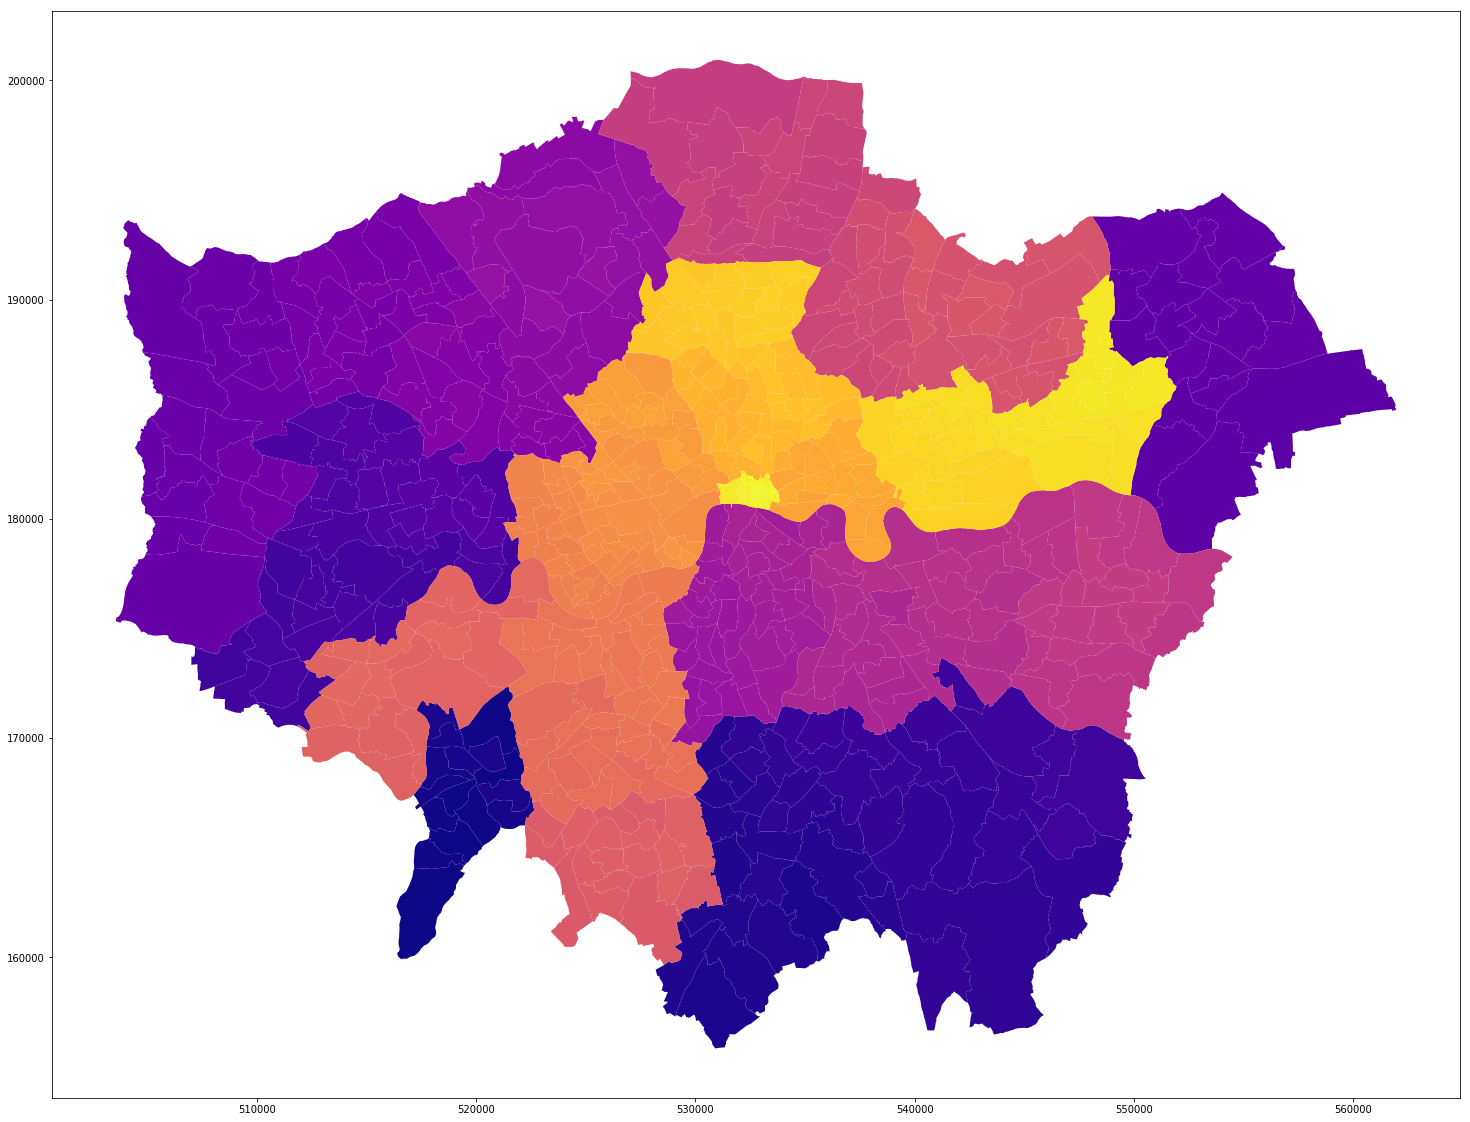

In [149]:
london.plot(figsize=(30,20),cmap = 'plasma')

(180000, 185000)

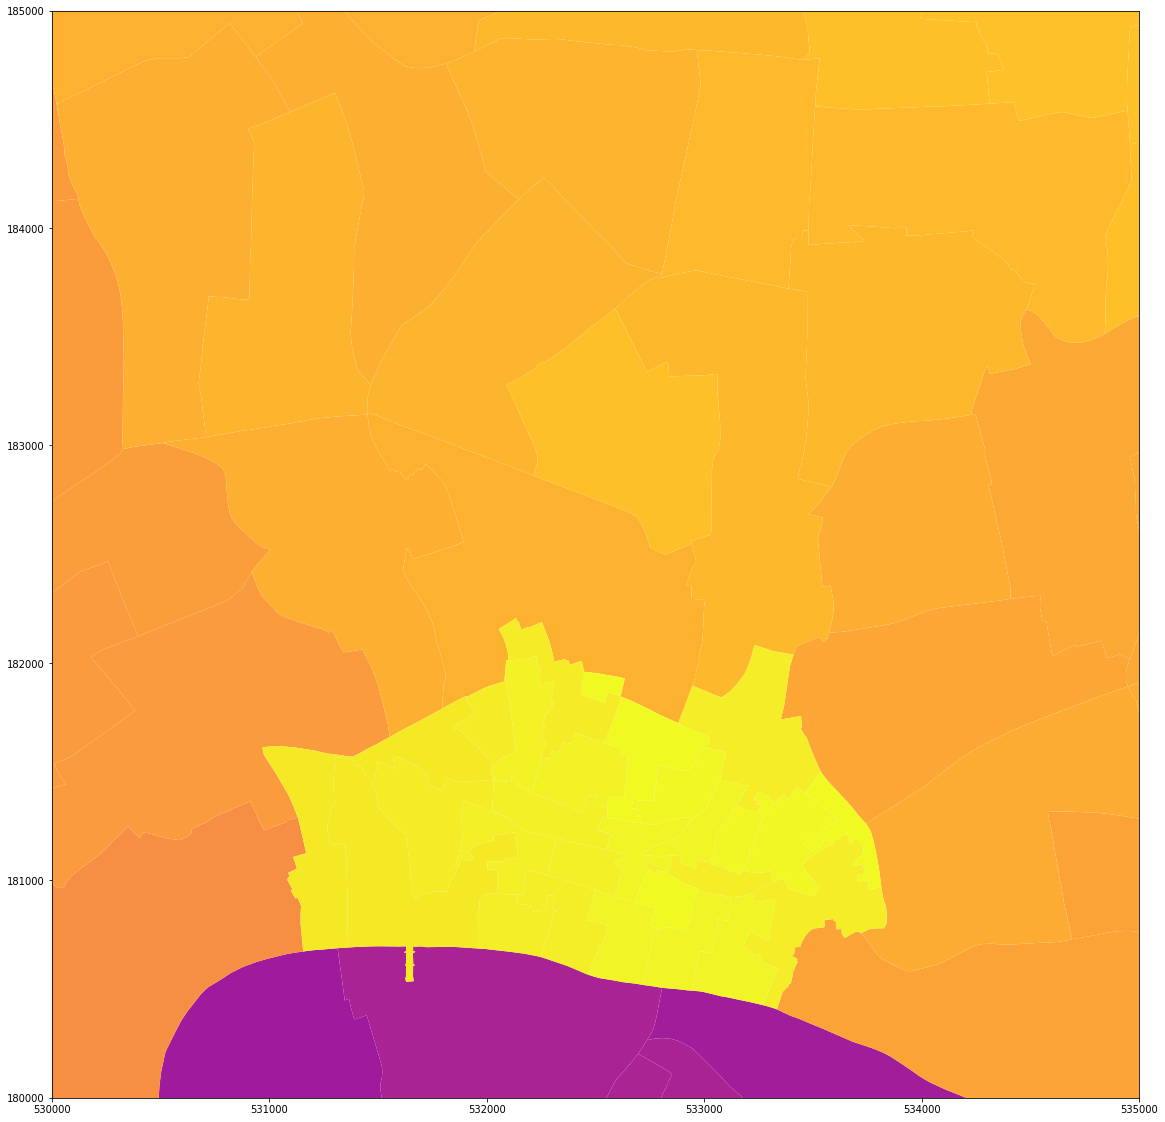

In [150]:
ax = london.plot(figsize = (30,20),cmap = 'plasma')
ax.set_xlim(530000,535000)
ax.set_ylim(180000,185000)

In [145]:
kings_gdf = gpd.GeoDataFrame([{"name": str(kings_loc),
                              "geometry": Point(kings_loc.longitude, kings_loc.latitude)}],
                            crs={'init' : 'epsg:4326'})
kings_gdf.head()

,geometry,name
0,POINT (-0.118014653020563 51.5146458),"Virginia Woolf Building (KCL), 22, Kingsway, S..."


In [148]:
kings_gdf = kings_gdf.to_crs(london.crs)
kings_gdf.head()

,geometry,name
0,POINT (530687.0852838805 181203.2668633842),"Virginia Woolf Building (KCL), 22, Kingsway, S..."


In [153]:
home_gdf = gpd.GeoDataFrame([{"name": str(home_address),
                              "geometry": Point(home_address.longitude, home_address.latitude)}],
                            crs={'init' : 'epsg:4326'})
home_gdf.head()

,geometry,name
0,POINT (-0.0777906 51.5496183),"Boleyn Road, Mayville Estate, Kingsland, Londo..."


In [155]:
home_gdf = home_gdf.to_crs(london.crs)
home_gdf.head()

,geometry,name
0,POINT (533375.8099412728 185164.8588846332),"Boleyn Road, Mayville Estate, Kingsland, Londo..."


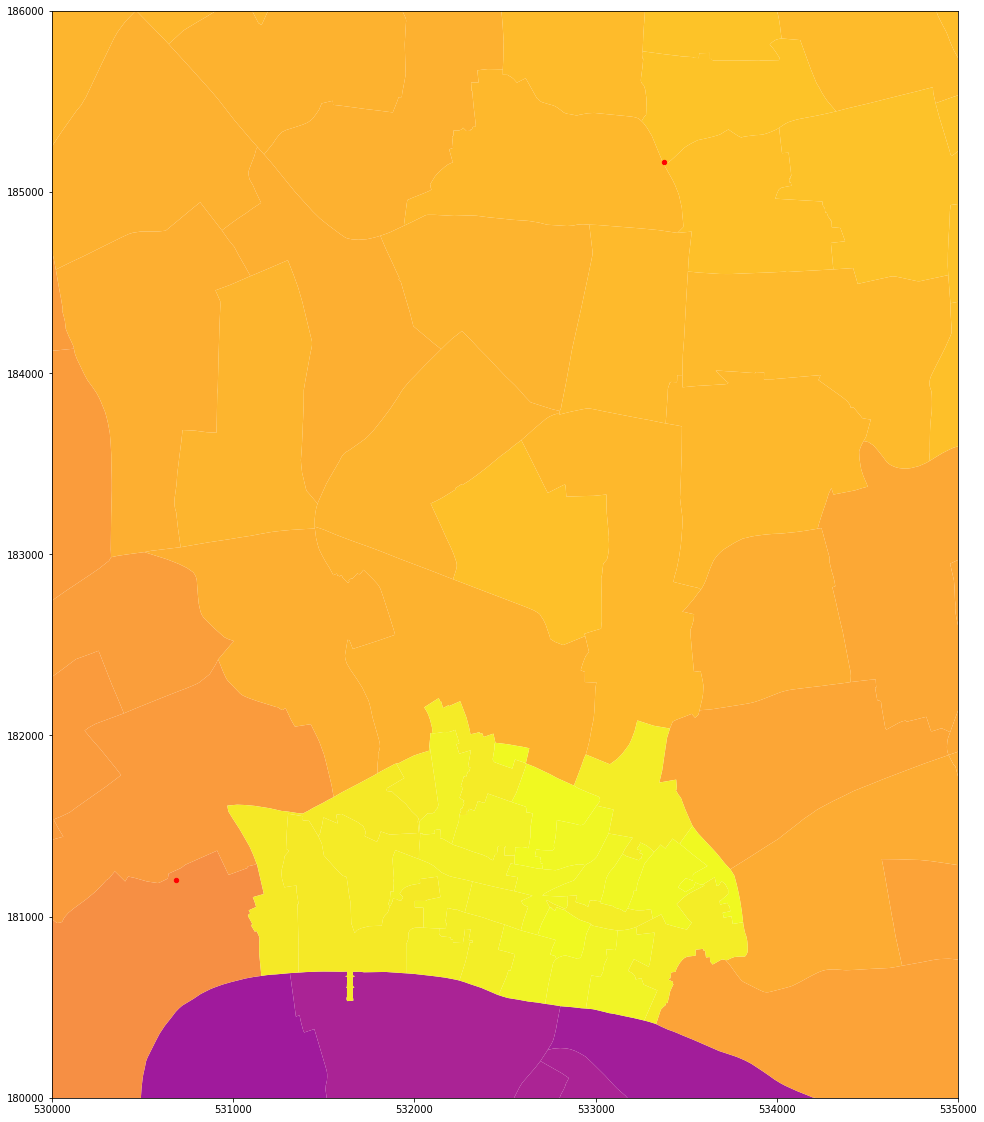

In [161]:
base = london.plot(figsize=(30,20),cmap = 'plasma')
base.set_xlim(530000,535000)
base.set_ylim(180000,186000)
home_gdf.plot(ax = base, marker = 'o', color = 'red', markersize = 19)
kings_gdf.plot(ax = base, marker = 'o', color = 'red', markersize = 19)

## Part 4 - London Bike Stations

In [170]:
import json
import pandas as pd

In [163]:
try:
    with open("data/BikePoints.json","r") as fd:
        bikes_json = json.load(fd)
except IOError as ioe:
    print("IOE error: %s" % ioe)

In [180]:
bikes_json['points'][0]['name']
name,lat,lon = [],[],[]
for i in bikes_json['points']:
    name.append(i['name'])
    lat.append(i['lat'])
    lon.append(i['lon'])

df = pd.DataFrame([name,lat,lon]).T
df.columns = ['name','lat','lon']

In [182]:
df.head()

,name,lat,lon
0,"River Street , Clerkenwell",51.5292,-0.10997
1,"Phillimore Gardens, Kensington",51.4996,-0.197574
2,"Christopher Street, Liverpool Street",51.5213,-0.084605
3,"St. Chad's Street, King's Cross",51.5301,-0.120973
4,"Sedding Street, Sloane Square",51.4931,-0.156876


In [190]:
df['Coordinates'] = list(zip(df.lon, df.lat))
df['Coordinates'] = df['Coordinates'].apply(Point)
bikes_gdf = gpd.GeoDataFrame(df, geometry='Coordinates', crs={'init' : 'epsg:4326'})
bikes_home_gdf = home_gdf.to_crs(london.crs)
home_gdf.head()gdf.head()

,name,lat,lon,Coordinates
0,"River Street , Clerkenwell",51.5292,-0.10997,POINT (-0.10997 51.529163)
1,"Phillimore Gardens, Kensington",51.4996,-0.197574,POINT (-0.197574 51.499606)
2,"Christopher Street, Liverpool Street",51.5213,-0.084605,POINT (-0.084605 51.521283)
3,"St. Chad's Street, King's Cross",51.5301,-0.120973,POINT (-0.120973 51.530059)
4,"Sedding Street, Sloane Square",51.4931,-0.156876,POINT (-0.156876 51.49313)


In [192]:
bikes_gdf = bikes_gdf.to_crs(london.crs)
bikes_gdf.head()

,name,lat,lon,Coordinates
0,"River Street , Clerkenwell",51.5292,-0.10997,POINT (531203.5579798035 182832.0141456951)
1,"Phillimore Gardens, Kensington",51.4996,-0.197574,POINT (525208.0892904003 179391.8163064686)
2,"Christopher Street, Liverpool Street",51.5213,-0.084605,POINT (532985.8604764383 182001.4870374107)
3,"St. Chad's Street, King's Cross",51.5301,-0.120973,POINT (530437.8087618067 182911.9952773479)
4,"Sedding Street, Sloane Square",51.4931,-0.156876,POINT (528050.9687698677 178742.0031481425)


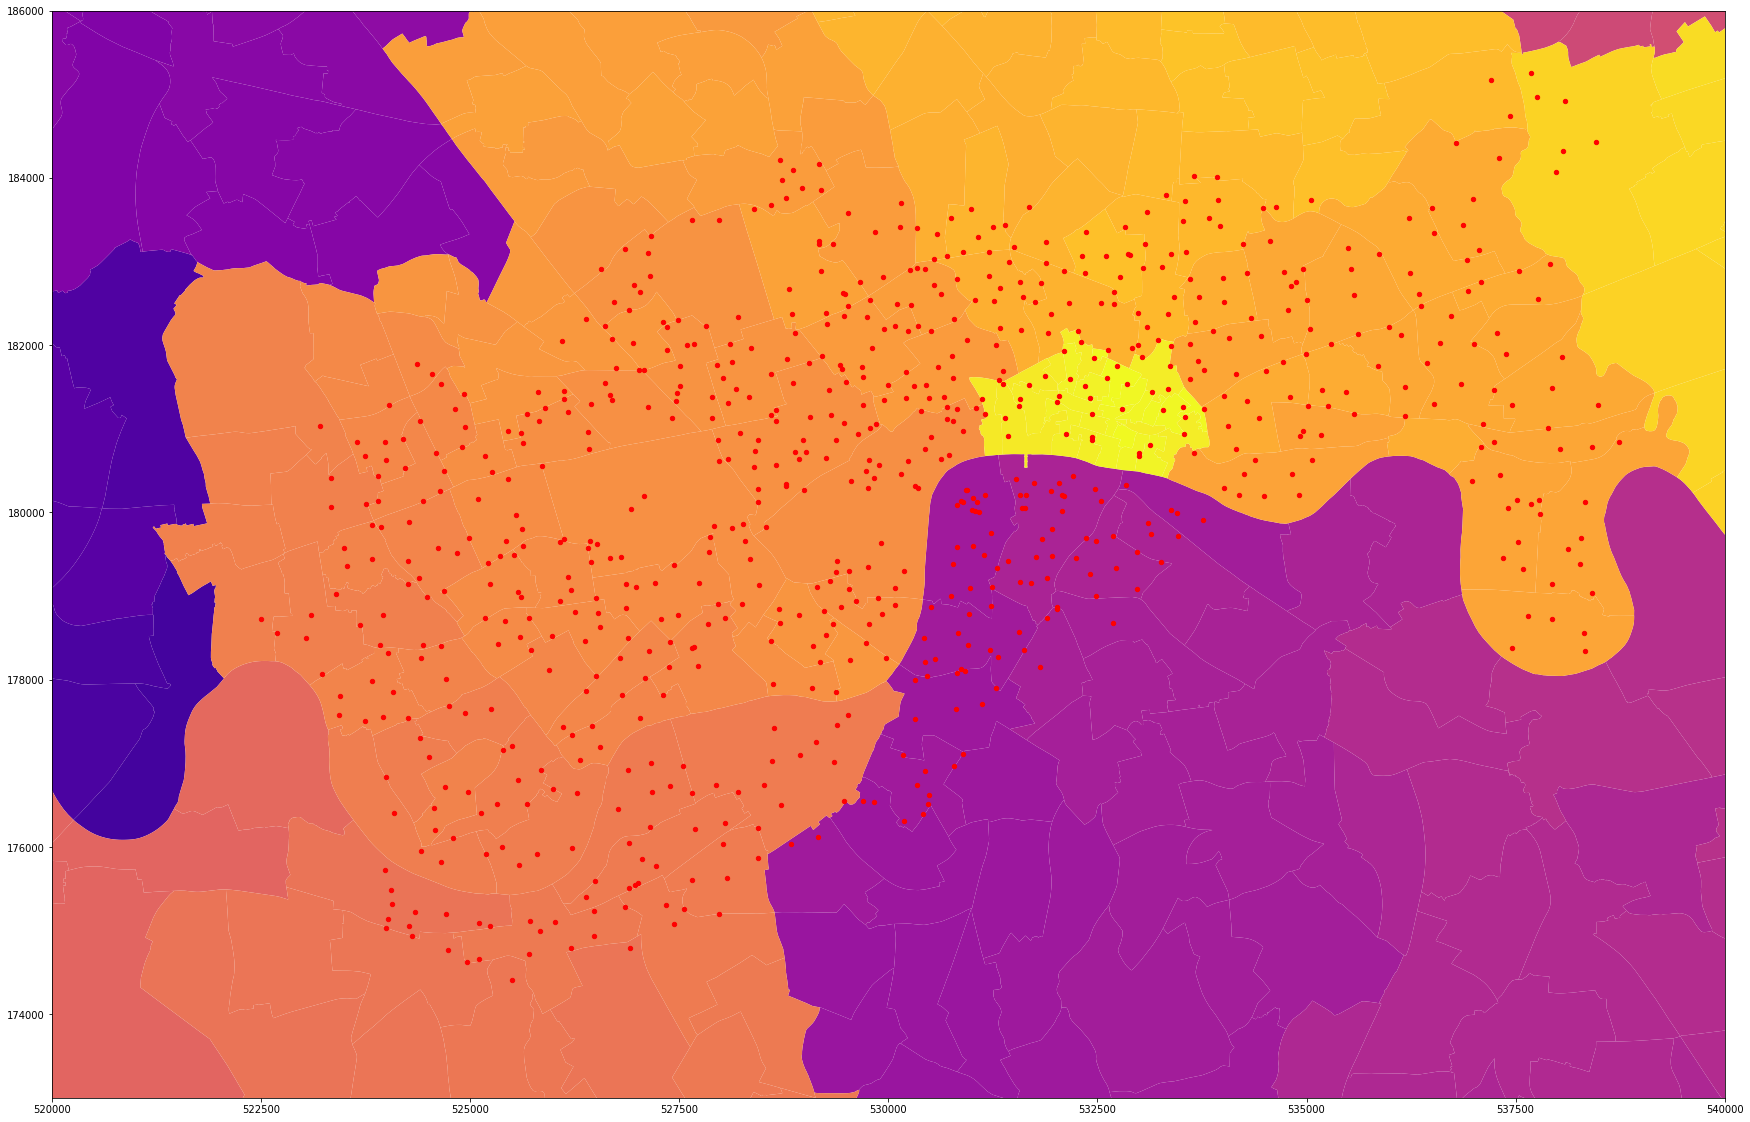

In [197]:
base = london.plot(figsize = (30,20),cmap = 'plasma')
base.set_xlim(520000,540000)
base.set_ylim(173000,186000)
bikes_gdf.plot(ax = base, marker = 'o', color = 'red', markersize = 19)